In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from AutoEncoderCNN import AE, Encoder, Decoder
from skimage.metrics import structural_similarity as ssim

print(torch.cuda.device_count())
print(torch.cuda.mem_get_info())    # (byte,byte)

1
(16790978560, 17059545088)


In [3]:
BATCH_SIZE = 32 # change smaller if running out of memory: [64,71) range

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) #+ datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
#                                                                                                                      tensor_transform,
#                                                                                                                      horizontal_flip
#                                                                                                                    ]))

In [4]:
SPLIT = [55767, 6971, 6971] # multiply each by 2 when doing horizontal flip

# SPLIT = [2001, 33854, 33854] # hyper-params tuning

train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,      # 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
enc_out = 8300
encoder = Encoder(out_channel = enc_out)

rand_mat_dim = 4096
decoder = Decoder(out_channel = rand_mat_dim)

In [6]:
rand_mat = torch.randn(enc_out, rand_mat_dim)/np.sqrt(rand_mat_dim)
rand_mat = rand_mat/torch.linalg.vector_norm(rand_mat,axis=1,keepdims=True).to(device)

In [7]:
print(f'{rand_mat.size()}')
rand_mat

torch.Size([8300, 4096])


tensor([[ 0.0233,  0.0187, -0.0021,  ...,  0.0035, -0.0074, -0.0073],
        [ 0.0259, -0.0170, -0.0287,  ..., -0.0079,  0.0018,  0.0130],
        [ 0.0245,  0.0189,  0.0155,  ...,  0.0144,  0.0117,  0.0269],
        ...,
        [ 0.0108, -0.0063,  0.0032,  ...,  0.0063, -0.0033, -0.0036],
        [-0.0102, -0.0126,  0.0085,  ..., -0.0240, -0.0185, -0.0106],
        [ 0.0107,  0.0003, -0.0151,  ...,  0.0201,  0.0281,  0.0139]],
       device='cuda:0')

In [8]:
with open('progress.txt', 'w') as file:
    file.write(f"{Encoder=}\n\n{Decoder=}\n\nTraining:\n")

In [9]:
EPOCHS = 20
loss_weights = [1, 5e-3, 5e-6] # 1e-4 too small for l2, try 1e-3 l2 and some small value for l3
early_stop_depth = 10
verbose = 1

LR = 5e-5
# WEIGHT_DECAY = 0.01

In [10]:
optimizer = torch.optim.Adam([{'params': encoder.parameters(),'lr': LR},
                              {'params': decoder.parameters(),'lr': LR}])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0
)

In [11]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
scheduler.gamma

0.98

In [ ]:
torch.autograd.set_detect_anomaly(True)

encoder.to(device)
decoder.to(device)

encoder.train()
decoder.train()

loss_arr = []

for epoch in range(EPOCHS):
    for img, _ in train_loader:  
        optimizer.zero_grad()

        img = img.to(device)
        p_vec = encoder(img)
        img_feature = p_vec@rand_mat
        recon = decoder(img_feature)
        
#         loss_mse = F.mse_loss(img, recon)
        loss_ssim = 0
        for i in range(img.size()[0]):
            loss_ssim += ssim(img[i].cpu().numpy(), recon[i].detach().cpu().numpy(), channel_axis=0, data_range=1.0)
        loss_ssim = 1 - loss_ssim/BATCH_SIZE # to minimize

        loss_entropy = -torch.sum(p_vec*torch.log(p_vec+1e-10))/BATCH_SIZE
        loss_dirichlet = -torch.sum(torch.log(torch.mean(p_vec+1e-10,dim=0)))
        
        loss =  (loss_weights[0] * loss_ssim +
                loss_weights[1] * loss_entropy +
                loss_weights[2] * loss_dirichlet)
        
        loss.backward()
        optimizer.step()
    scheduler.step()
    
    loss_arr.append(loss.item())
    text = f'\nEpoch: {epoch + 1} | Loss: {loss.item():.4f}'
    print(text, end='\n'*2)
    with open('progress.txt', 'a') as file:
        file.write(f"{text}\n\n")
        
        
print('Finished Training')


Epoch: 1 | Loss: 1.3760


Epoch: 2 | Loss: 1.3786


Epoch: 3 | Loss: 1.3762


Epoch: 4 | Loss: 1.3771


Epoch: 5 | Loss: 1.3791



In [ ]:
torch.save(rand_mat, f'./models/rand_mat.pth')
torch.save(encoder.state_dict(), f'./models/encoder.pth')
torch.save(decoder.state_dict(), f'./models/decoder.pth')

with open('progress.txt', 'a') as file:
    file.write(f"Saved\n\n")
print("done")

In [14]:
with open('progress.txt', 'a') as file:
    file.write(f"{loss_arr}\n\n")

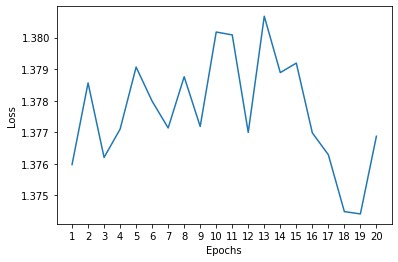

In [15]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [8]:
torch.set_default_device('cuda')

MAIN_PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'
tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)


# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) # + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
#                                                                                                                       tensor_transform,
#                                                                                                                       horizontal_flip
#                                                                                                                     ]))
SPLIT = [55767, 6971, 6971]  # multiply by 2 for horizontal flip

_, val_set, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [9]:
rand_mat

tensor([[ 0.0233,  0.0187, -0.0021,  ...,  0.0035, -0.0074, -0.0073],
        [ 0.0259, -0.0170, -0.0287,  ..., -0.0079,  0.0018,  0.0130],
        [ 0.0245,  0.0189,  0.0155,  ...,  0.0144,  0.0117,  0.0269],
        ...,
        [ 0.0108, -0.0063,  0.0032,  ...,  0.0063, -0.0033, -0.0036],
        [-0.0102, -0.0126,  0.0085,  ..., -0.0240, -0.0185, -0.0106],
        [ 0.0107,  0.0003, -0.0151,  ...,  0.0201,  0.0281,  0.0139]],
       device='cuda:0')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(out_channel = enc_out)
decoder = Decoder(out_channel = rand_mat_dim)
temp = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
temp = rand_mat.div(torch.norm(rand_mat, dim = 0))


encoder.load_state_dict(torch.load('./models/encoder.pth'))
decoder.load_state_dict(torch.load('./models/decoder.pth'))
rand_mat = torch.load('./models/rand_mat.pth')

In [14]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
ssim_running_total = 0
count = 0

torch.set_default_device('cuda')

encoder.eval()
decoder.eval()
for (inp, _) in val_loader:
    with torch.no_grad():
        inp = inp.to(device)
        p_vec = encoder(inp)@rand_mat
        oup = decoder(p_vec)
        
        if count % 100 == 0:
            encoded_imgs_arr.append(p_vec)
        
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()
        loss_ssim = 0
        for i in range(inp.size()[0]):
            loss_ssim += ssim(inp[i].cpu().numpy(), oup[i].detach().cpu().numpy(), channel_axis=0, data_range=1.0)
        ssim_running_total += loss_ssim/BATCH_SIZE
        

                
        if count % 100 == 0:
            auto_encoder_output.append((inp, oup))
        count += 1

In [15]:
mse_running_total/len(val_loader)

0.08989914283348778

In [16]:
ssim_running_total/len(val_loader)

0.001061404092151549

In [21]:
x = encoded_imgs_arr[0]
y = encoded_imgs_arr[10]

In [22]:
x[0]

tensor([ 0.0002,  0.0002, -0.0004,  ...,  0.0014, -0.0005,  0.0009],
       device='cuda:0')

In [23]:
y[0]

tensor([-8.1905e-04,  6.1809e-05, -1.7276e-05,  ...,  6.2636e-04,
         8.5162e-04,  1.4569e-03], device='cuda:0')

In [24]:
x[0]-y[0]

tensor([ 0.0010,  0.0001, -0.0004,  ...,  0.0007, -0.0014, -0.0006],
       device='cuda:0')

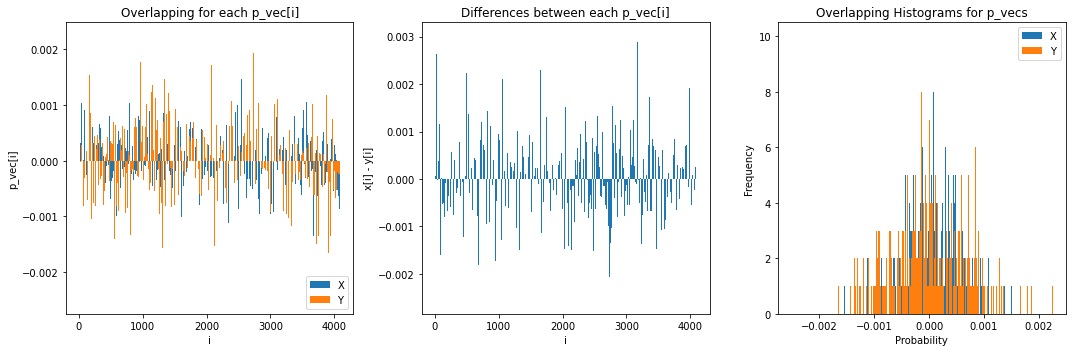

In [25]:
arr = [i+1 for i in range(len(x[0]))]
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.bar(arr, x[0].cpu().numpy(), label = 'X');
plt.bar(arr, y[0].cpu().numpy(), label = 'Y');

plt.legend(loc='lower right') 
plt.xlabel('i')
plt.ylabel('p_vec[i]')
plt.title('Overlapping for each p_vec[i]') 

plt.subplot(1,3,2)
plt.bar(arr, (x[0]-y[0]).cpu().numpy());
plt.xlabel('i')
plt.ylabel('x[i] - y[i]')
plt.title('Differences between each p_vec[i]') 

plt.subplot(1,3,3)
plt.hist(x[0].cpu().numpy(), bins=len(x[0]), label='X');
plt.hist(y[0].cpu().numpy(), bins=len(y[0]), label='Y');
plt.xlabel('Probability')
plt.ylabel('Frequency')
  
plt.legend(loc='upper right') 
plt.title('Overlapping Histograms for p_vecs') 

plt.tight_layout()
plt.show()

In [26]:
mse_running_total = 0
encoder.eval()
decoder.eval()

for (img, _) in val_loader:
    with torch.no_grad():

        inp = img.to(device)
        p_vec = encoder(inp)
        oup = decoder(p_vec@rand_mat)
        
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()
        break

torch.Size([3, 299, 299])
0.09462638199329376


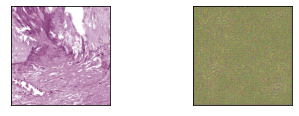

In [27]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = oup.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

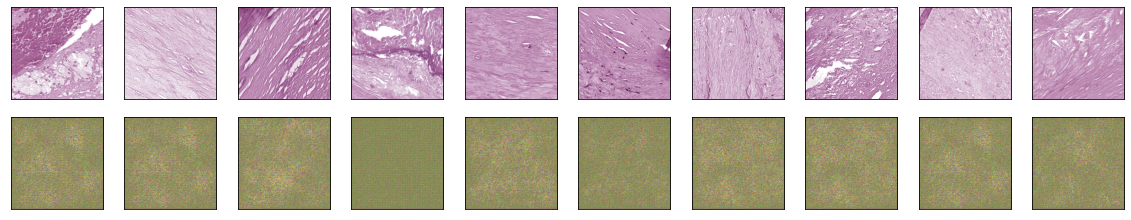

In [28]:
# Validation Set Images
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)